In [66]:
import pathlib
import matplotlib
import numpy as np
from torchvision import transforms


from dataset import SegmentationDataset, get_dataloaders, DualCompose, DualResize, RandomRotationDual, RandomFlipDual

In [67]:
# Define transformations for images and masks
# Ensure paired image/mask get identical random ops and fixed size
target_size = (512, 512)

joint_transform = DualCompose([
    DualResize(target_size),  # Fixed size for batching
    RandomRotationDual(degrees=15),
    RandomFlipDual(flip_type="horizontal", p=0.5),
    RandomFlipDual(flip_type="vertical", p=0.3),
])

image_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    # transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.2),
    # transforms.RandomApply([transforms.RandomAdjustSharpness(2.0)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())
])


In [68]:
# Create the dataset
dataset = SegmentationDataset(
    images_dir='data/training/original',
    masks_dir='data/training/gt',
    joint_transform=joint_transform,
    image_transform=image_transform,
    mask_transform=mask_transform
)
eval_dataset = SegmentationDataset(
    images_dir='data/testing/original',
    masks_dir='data/testing/gt',
    joint_transform=joint_transform,
    image_transform=image_transform,
    mask_transform=mask_transform
)


train_loader, val_loader = get_dataloaders(dataset, t_size=0.8, v_size=0.2, eval=False)
eval_loader, _ = get_dataloaders(eval_dataset, t_size=1, v_size=0, eval=False)

print(f"Train samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Evaluation samples: {len(eval_loader.dataset)}")
print(f"Total samples: {len(train_loader.dataset) + len(val_loader.dataset) + len(eval_loader.dataset)}")

Train samples: 720
Validation samples: 180
Evaluation samples: 379
Total samples: 1279


In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [70]:
class ImprovedUNet(nn.Module):
    def __init__(self, img_size, num_classes, dropout=True, use_batch_norm=True):
        super(ImprovedUNet, self).__init__()

        dropout_rate = 0.2 if dropout else 0
        
        # Encoder (Contracting Path)
        self.enc1 = EncoderBlock(3, 64, dropout_rate)       # 256x256 -> 128x128
        self.enc2 = EncoderBlock(64, 128, dropout_rate)     # 128x128 -> 64x64
        self.enc3 = EncoderBlock(128, 256, dropout_rate)    # 64x64 -> 32x32
        self.enc4 = EncoderBlock(256, 512, dropout_rate)    # 32x32 -> 16x16
        self.enc5 = EncoderBlock(512, 1024, dropout_rate)   # 16x16 -> 8x8
        
        # Bottleneck
        self.bottleneck = EncoderBlock(512, 1024) # 16x16 -> 8x8
        # self.bottleneck = EncoderBlock(1024, 2048) # 16x16 -> 8x8
        
        # Decoder (Expanding Path) with skip connections
        self.dec5 = DecoderBlock(2048, 1024, dropout_rate)  # 4x4 -> 8x8 (skip from enc5)
        self.dec4 = DecoderBlock(1024, 512, dropout_rate)   # 8x8 -> 16x16 (skip from enc4)
        self.dec3 = DecoderBlock(512, 256, dropout_rate)    # 16x16 -> 32x32 (skip from enc3)
        self.dec2 = DecoderBlock(256, 128, dropout_rate)    # 32x32 -> 64x64 (skip from enc2)
        self.dec1 = DecoderBlock(128, 64, dropout_rate)     # 64x64 -> 128x128 (skip from enc1)
        
        # Final upsampling to original size
        self.final_upsample = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)
        
    def forward(self, x):
        # Encoder path
        e1, skip1 = self.enc1(x)      # 256x256 -> 128x128, 64 channels
        e2, skip2 = self.enc2(e1)    # 128x128 -> 64x64, 128 channels
        e3, skip3 = self.enc3(e2)    # 64x64 -> 32x32, 256 channels
        e4, skip4 = self.enc4(e3)    # 32x32 -> 16x16, 512 channels
        # e5, skip5 = self.enc5(e4)    # 16x16 -> 8x8, 1024 channels
        
        # Bottleneck
        b, _ = self.bottleneck(e4)    # 8x8 -> 4x4, 2048 channels
        
        # Decoder path with skip connections
        # d5 = self.dec5(b, skip5)      # 4x4 -> 8x8, 1024 channels
        d4 = self.dec4(b, skip4)      # 8x8 -> 16x16, 512 channels
        d3 = self.dec3(d4, skip3)      # 16x16 -> 32x32, 256 channels
        d2 = self.dec2(d3, skip2)      # 32x32 -> 64x64, 128 channels
        d1 = self.dec1(d2, skip1)      # 64x64 -> 128x128, 64 channels
        
        # Final upsampling and classification
        x = self.final_upsample(d1)   # 128x128 -> 256x256, 32 channels
        x = self.final_conv(x)        # 256x256 -> 256x256, 1 channel
        x = torch.sigmoid(x)
        
        return x


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2, use_batch_norm=True):
        super(EncoderBlock, self).__init__()

        self.dropout_rate = dropout_rate

        norm_layer = nn.BatchNorm2d if use_batch_norm else nn.InstanceNorm2d
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.in1 = norm_layer(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.in2 = norm_layer(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = F.relu(self.in1(self.conv1(x)))
        x = F.relu(self.in2(self.conv2(x)))
        skip = x  # Store for skip connection
        x = self.pool(x)
        if self.dropout_rate > 0:
            x = F.dropout2d(x, p=self.dropout_rate, training=self.training)
        return x, skip


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2, use_batch_norm=True):
        super(DecoderBlock, self).__init__()

        self.dropout_rate = dropout_rate
        norm_layer = nn.BatchNorm2d if use_batch_norm else nn.InstanceNorm2d
        # Upsampling
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        
        # Convolutions after concatenation - Fixed input channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.in1 = norm_layer(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.in2 = norm_layer(out_channels)
        
    def forward(self, x, skip):
        # Upsample
        x = self.up(x)
        
        # Ensure skip connection has the same spatial dimensions
        if x.shape[2:] != skip.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
        
        # Concatenate with skip connection
        x = torch.cat([x, skip], dim=1)
        
        # Convolutions
        x = F.relu(self.in1(self.conv1(x)))
        x = F.relu(self.in2(self.conv2(x)))
        if self.dropout_rate > 0:
            x = F.dropout2d(x, p=self.dropout_rate, training=self.training)

        return x


In [71]:
img_size = target_size 
num_classes = 1         # Single channel output for binary segmentation (0 or 1)
model = ImprovedUNet(img_size, num_classes, dropout=False, use_batch_norm=True)

In [72]:
from scipy import ndimage as ndi

def _mask_edges(mask: np.ndarray) -> np.ndarray:
    mask = mask.astype(bool)
    if mask.sum() == 0:
        return mask
    footprint = np.ones((3, 3), dtype=bool)
    eroded = ndi.binary_erosion(mask, structure=footprint)
    return np.logical_xor(mask, eroded)

def hausdorff(pred: np.ndarray, gt: np.ndarray, percentile=95, spacing=(1.0, 1.0)) -> float:
    pred_bin = pred > 0.5
    gt_bin = gt > 0.5
    if pred_bin.sum() == 0 and gt_bin.sum() == 0:
        return 0.0
    if pred_bin.sum() == 0 or gt_bin.sum() == 0:
        return float("inf")

    pred_edge = _mask_edges(pred_bin)
    gt_edge = _mask_edges(gt_bin)

    if pred_edge.sum() == 0 and gt_edge.sum() == 0:
        return 0.0
    if pred_edge.sum() == 0 or gt_edge.sum() == 0:
        return float("inf")

    dt_pred = ndi.distance_transform_edt(~pred_edge, sampling=spacing)
    dt_gt = ndi.distance_transform_edt(~gt_edge, sampling=spacing)

    dists = np.concatenate([dt_pred[gt_edge], dt_gt[pred_edge]])
    if dists.size == 0:
        return 0.0
    return float(np.percentile(dists, percentile))

In [73]:
import torch.optim as optim


class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5, smooth=1e-6, reduction='mean'):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.smooth = smooth
        self.reduction = reduction
        self.bce = nn.BCELoss(reduction=reduction)  # model outputs probs (sigmoid), so BCELoss is correct

    def forward(self, preds, targets):
        # preds, targets: N x 1 x H x W, preds are probabilities in [0,1]
        preds = preds.clamp(min=self.smooth, max=1.0 - self.smooth)

        # BCE
        bce_loss = self.bce(preds, targets)

        # Dice (computed per-sample, then averaged)
        dims = (1, 2, 3)
        intersection = (preds * targets).sum(dims)
        preds_sum = preds.sum(dims)
        targets_sum = targets.sum(dims)
        dice = (2.0 * intersection + self.smooth) / (preds_sum + targets_sum + self.smooth)
        dice_loss = 1.0 - dice
        if self.reduction == 'mean':
            dice_loss = dice_loss.mean()
        elif self.reduction == 'sum':
            dice_loss = dice_loss.sum()

        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

class BCEHousdorffLoss(nn.Module):
    def __init__(self, bce_weight=0.5, smooth=1e-6, percentile=95, eps=1e-6, reduction='mean'):
        super().__init__()
        self.bce_weight = bce_weight
        self.smooth = smooth
        self.percentile = percentile
        self.eps = eps
        self.bce = nn.BCELoss(reduction=reduction)  # model outputs probs (sigmoid), so BCELoss is correct


    def hausdorff(self, preds, targets):
        # This Hausdorff loss calculation differs from the previously implemented hausdorff function in two main ways:
        # 1. It computes a *soft* Hausdorff-like loss by weighting per-pixel errors with distances from the ground truth 
        #    boundaries, rather than thresholding predictions and computing Hausdorff directly on binary masks.
        # 2. Instead of using direct percentile distances between predicted and ground truth edges, it selects the top-k
        #    weighted error pixels (determined by the given percentile) and averages them to provide a differentiable estimate 
        #    that is friendly to optimization, making it suitable as a training loss.

        # preds, targets: [N, 1, H, W], preds in [0,1]
        preds = preds.clamp(self.eps, 1.0 - self.eps)
        N = preds.shape[0]
        losses = []
        for n in range(N):
            y = (targets[n, 0] > 0.5).detach().cpu().numpy().astype(bool)
            # Distance to fg and bg (robust boundary emphasis)
            dt_fg = ndi.distance_transform_edt(~y)
            dt_bg = ndi.distance_transform_edt(y)
            dist = torch.from_numpy(dt_fg + dt_bg).to(preds.device, dtype=preds.dtype)

            err = (preds[n, 0] - targets[n, 0]).abs()         # per-pixel soft error
            weighted = err * dist                              # HD-like weighting
            flat = weighted.flatten()

            k = max(1, int(np.ceil(flat.numel() * (self.percentile / 100.0))))
            topk_vals, _ = torch.topk(flat, k, largest=True)
            losses.append(topk_vals.mean())
        return torch.stack(losses).mean()

    def forward(self, preds, targets):
        # preds, targets: N x 1 x H x W, preds are probabilities in [0,1]
        preds = preds.clamp(min=self.smooth, max=1.0 - self.smooth)

        # BCE
        bce_loss = self.bce(preds, targets)

        # Hausdorff distance
        hausdorff = self.hausdorff(preds, targets)

        return self.bce_weight * bce_loss + 0.5 * hausdorff


# Binary Cross Entropy Loss for segmentation
criterion = nn.BCELoss()
# criterion = BCEDiceLoss()
# criterion = BCEHousdorffLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)#, weight_decay=0.0001)

print("Loss function and optimizer defined:")
print(f"Loss: {criterion}")
print(f"Optimizer: {optimizer}")

Loss function and optimizer defined:
Loss: BCELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [74]:
# Training function with accuracy tracking
def train_epoch(model, dataloader, criterion, optimizer, device='cpu'):
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

# Validation function with comprehensive metrics tracking
def validate_epoch(model, dataloader, criterion, device='cpu'):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    total_accuracy = 0.0
    total_sensitivity = 0.0
    total_specificity = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Calculate metrics
            pred_binary = (outputs > 0.5).float()
            
            # Accuracy
            accuracy = (pred_binary == masks).float().mean()
            total_accuracy += accuracy.item()
            
            # IoU (Intersection over Union)
            intersection = (pred_binary * masks).sum(dim=(1, 2, 3))  # Sum over spatial dimensions
            union = (pred_binary + masks - pred_binary * masks).sum(dim=(1, 2, 3))
            iou = (intersection / (union + 1e-8)).mean()  # Average IoU across batch
            total_iou += iou.item()
            
            # Dice Coefficient
            dice = (2 * intersection / (pred_binary.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) + 1e-8)).mean()
            total_dice += dice.item()

            # Confusion matrix components
            tp = torch.logical_and(pred_binary == 1, masks == 1).sum()
            tn = torch.logical_and(pred_binary == 0, masks == 0).sum()
            fp = torch.logical_and(pred_binary == 1, masks == 0).sum()
            fn = torch.logical_and(pred_binary == 0, masks == 1).sum()

            # Sensitivity (Recall) and Specificity
            total_sensitivity += tp / (tp + fn + 1e-8)
            total_specificity += tn / (tn + fp + 1e-8)
            
            total_loss += loss.item()
            num_batches += 1
    
    return (total_loss / num_batches, 
            total_accuracy / num_batches, 
            total_iou / num_batches, 
            total_dice / num_batches,
            total_sensitivity / num_batches,
            total_specificity / num_batches)

In [75]:
# Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps")
print(f"Using device: {device}")

force_train = True
validation_metric = "accuracy"

# Move model to device
model = model.to(device)

model_file = pathlib.Path("improved_segmentation_model1.pth")
if model_file.exists() and not force_train:
    model.load_state_dict(torch.load(model_file))
    print(f"Model loaded from {model_file}")
else:
    # Training parameters with convergence detection
    max_epochs = 8  # Increased max epochs
    patience = 8     # Number of epochs to wait for improvement
    min_delta = 0.001  # Minimum change to qualify as improvement
    
    # Convergence tracking variables
    best_val = 0.0
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    best_val_iou = 0.0
    best_val_dice = 0.0
    epochs_without_improvement = 0
    early_stop = False
    
    # Lists to track training history for convergence analysis
    train_losses = []
    val_losses = []
    val_dice_scores = []
    val_iou_scores = []
    val_sensitivity_scores = []
    val_specificity_scores = []

    print("Starting training with convergence detection...")
    print(f"Max epochs: {max_epochs}, Patience: {patience}, Min delta: {min_delta}")
    
    for epoch in range(max_epochs):
        # Training
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_loss, val_accuracy, val_iou, val_dice, val_sensitivity, val_specificity = validate_epoch(model, val_loader, criterion, device)
        
        # Store metrics for convergence analysis
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        val_iou_scores.append(val_iou)
        val_sensitivity_scores.append(val_sensitivity)
        val_specificity_scores.append(val_specificity)
        
        print(f"Epoch {epoch+1}/{max_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"  Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}")
        
        # Check for improvement (using Dice coefficient as primary metric)
        if validation_metric == "dice":
            improvement = val_dice > best_val_dice + min_delta
            value = val_dice
            val_name = "Dice"
        elif validation_metric == "accuracy":
            improvement = val_accuracy > best_val_accuracy + min_delta
            value = val_accuracy
            val_name = "Accuracy"
        elif validation_metric == "iou":
            improvement = val_iou > best_val_iou + min_delta
            value = val_iou
            val_name = "IoU"
        if improvement:
            # Save best model
            best_val = value
            best_val_iou = val_iou
            best_val_dice = val_dice
            best_val_accuracy = val_accuracy
            best_val_loss = val_loss
            best_val_sensitivity = val_sensitivity
            best_val_specificity = val_specificity
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_segmentation_model.pth')
            print(f"  New best model saved! ({val_name}: {best_val:.4f})")
        else:
            epochs_without_improvement += 1
            print(f"  No improvement for {epochs_without_improvement} epochs")
        
        # Check for convergence/early stopping
        if epochs_without_improvement >= patience:
            early_stop = True
            print(f"\n Early stopping triggered!")
            print(f"   No improvement in {val_name} score for {patience} epochs")
            print(f"   Best {val_name} score: {best_val:.4f}")
            break
        
        # Check for convergence based on loss stability
        if epoch >= 5:  # Need at least 5 epochs to check convergence
            recent_losses = val_losses[-5:]  # Last 5 epochs
            loss_std = np.std(recent_losses)
            loss_mean = np.mean(recent_losses)
            cv = loss_std / (loss_mean + 1e-8)  # Coefficient of variation
            
            if cv < 0.01:  # Very stable loss (CV < 1%)
                print(f"   Loss convergence detected (CV: {cv:.4f})")
                if epochs_without_improvement >= 3:  # Also need some patience
                    early_stop = True
                    print(f"\n Convergence-based early stopping!")
                    print(f"   Loss coefficient of variation: {cv:.4f}")
                    break
        
        print("-" * 50)

    if not early_stop:
        print("Training completed - reached maximum epochs!")
    
    print(f"\nFinal Results:")
    print(f"  Total epochs trained: {epoch + 1}")
    print(f"  Best validation metrics:")
    print(f"    IoU: {best_val_iou:.4f}")
    print(f"    Dice: {best_val_dice:.4f}")
    print(f"    Accuracy: {best_val_accuracy:.4f}")
    print(f"    Loss: {best_val_loss:.4f}")
    print(f"    Sensitivity: {best_val_sensitivity:.4f}")
    print(f"    Specificity: {best_val_specificity:.4f}")
    

Using device: mps
Starting training with convergence detection...
Max epochs: 8, Patience: 8, Min delta: 0.001
Epoch 1/8:
  Train Loss: 0.4194
  Val Loss: 0.4108, Val Accuracy: 0.8494
  Val IoU: 0.6171, Val Dice: 0.7212
  New best model saved! (Accuracy: 0.8494)
--------------------------------------------------


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataloader, num_images=5, device='cpu'):
    """
    Visualize model predictions on evaluation set
    
    Args:
        model: Trained U-Net model
        dataloader: Evaluation dataloader
        num_images: Number of images to display
        device: Device to run inference on
    """
    model.eval()
    
    # Get first num_images from dataloader
    images_to_show = []
    masks_to_show = []
    predictions_to_show = []
    
    with torch.no_grad():
        for i, (image, mask) in enumerate(dataloader):
            # Move to device
            image = image.to(device)
            
            # Get prediction
            outputs = model(image)
            prediction = (outputs > 0.5).float()

            if i >= num_images:
                pred_np = prediction[0].cpu().numpy().squeeze()
                predictions_to_show.append(pred_np)
                continue
            
            # Convert to numpy for visualization
            image_np = image[0].cpu().numpy().transpose(1, 2, 0)
            mask_np = mask[0].cpu().numpy().squeeze()
            pred_np = prediction[0].cpu().numpy().squeeze()
            
            # Denormalize image (reverse ImageNet normalization)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = image_np * std + mean
            image_np = np.clip(image_np, 0, 1)
            
            images_to_show.append(image_np)
            masks_to_show.append(mask_np)
            predictions_to_show.append(pred_np)
    
    # Create visualization
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_images):
        # Original image
        axes[i, 0].imshow(images_to_show[i])
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')
        
        # Ground truth mask
        axes[i, 1].imshow(masks_to_show[i], cmap='gray')
        axes[i, 1].set_title(f'Ground Truth {i+1}')
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(predictions_to_show[i], cmap='gray')
        axes[i, 2].set_title(f'Prediction {i+1}')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return images_to_show, masks_to_show, predictions_to_show

def calculate_metrics(prediction, ground_truth, threshold=0.5):
    """
    Calculate segmentation metrics
    
    Args:
        prediction: Model prediction (0-1)
        ground_truth: Ground truth mask (0-1)
        threshold: Threshold for binary prediction
    
    Returns:
        dict: Dictionary containing metrics
    """
    # Convert to binary
    pred_binary = (prediction > threshold).astype(np.uint8)
    gt_binary = ground_truth.astype(np.uint8)
    
    # Calculate metrics
    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    
    # IoU (Jaccard Index)
    iou = intersection / (union + 1e-8)
    
    # Dice Coefficient
    dice = (2 * intersection) / (pred_binary.sum() + gt_binary.sum() + 1e-8)
    
    # Accuracy
    accuracy = np.mean(pred_binary == gt_binary)

    # Confusion matrix components
    tp = np.logical_and(pred_binary == 1, gt_binary == 1).sum()
    tn = np.logical_and(pred_binary == 0, gt_binary == 0).sum()
    fp = np.logical_and(pred_binary == 1, gt_binary == 0).sum()
    fn = np.logical_and(pred_binary == 0, gt_binary == 1).sum()

    # Sensitivity (Recall) and Specificity
    sensitivity = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)

    # Hausdorff distance
    h = hausdorff(pred_binary, gt_binary)
    
    return {
        'IoU': iou,
        'Dice': dice,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Hausdorff': h
    }

print("Visualization functions defined!")

Visualization functions defined!


Visualizing predictions on evaluation set...


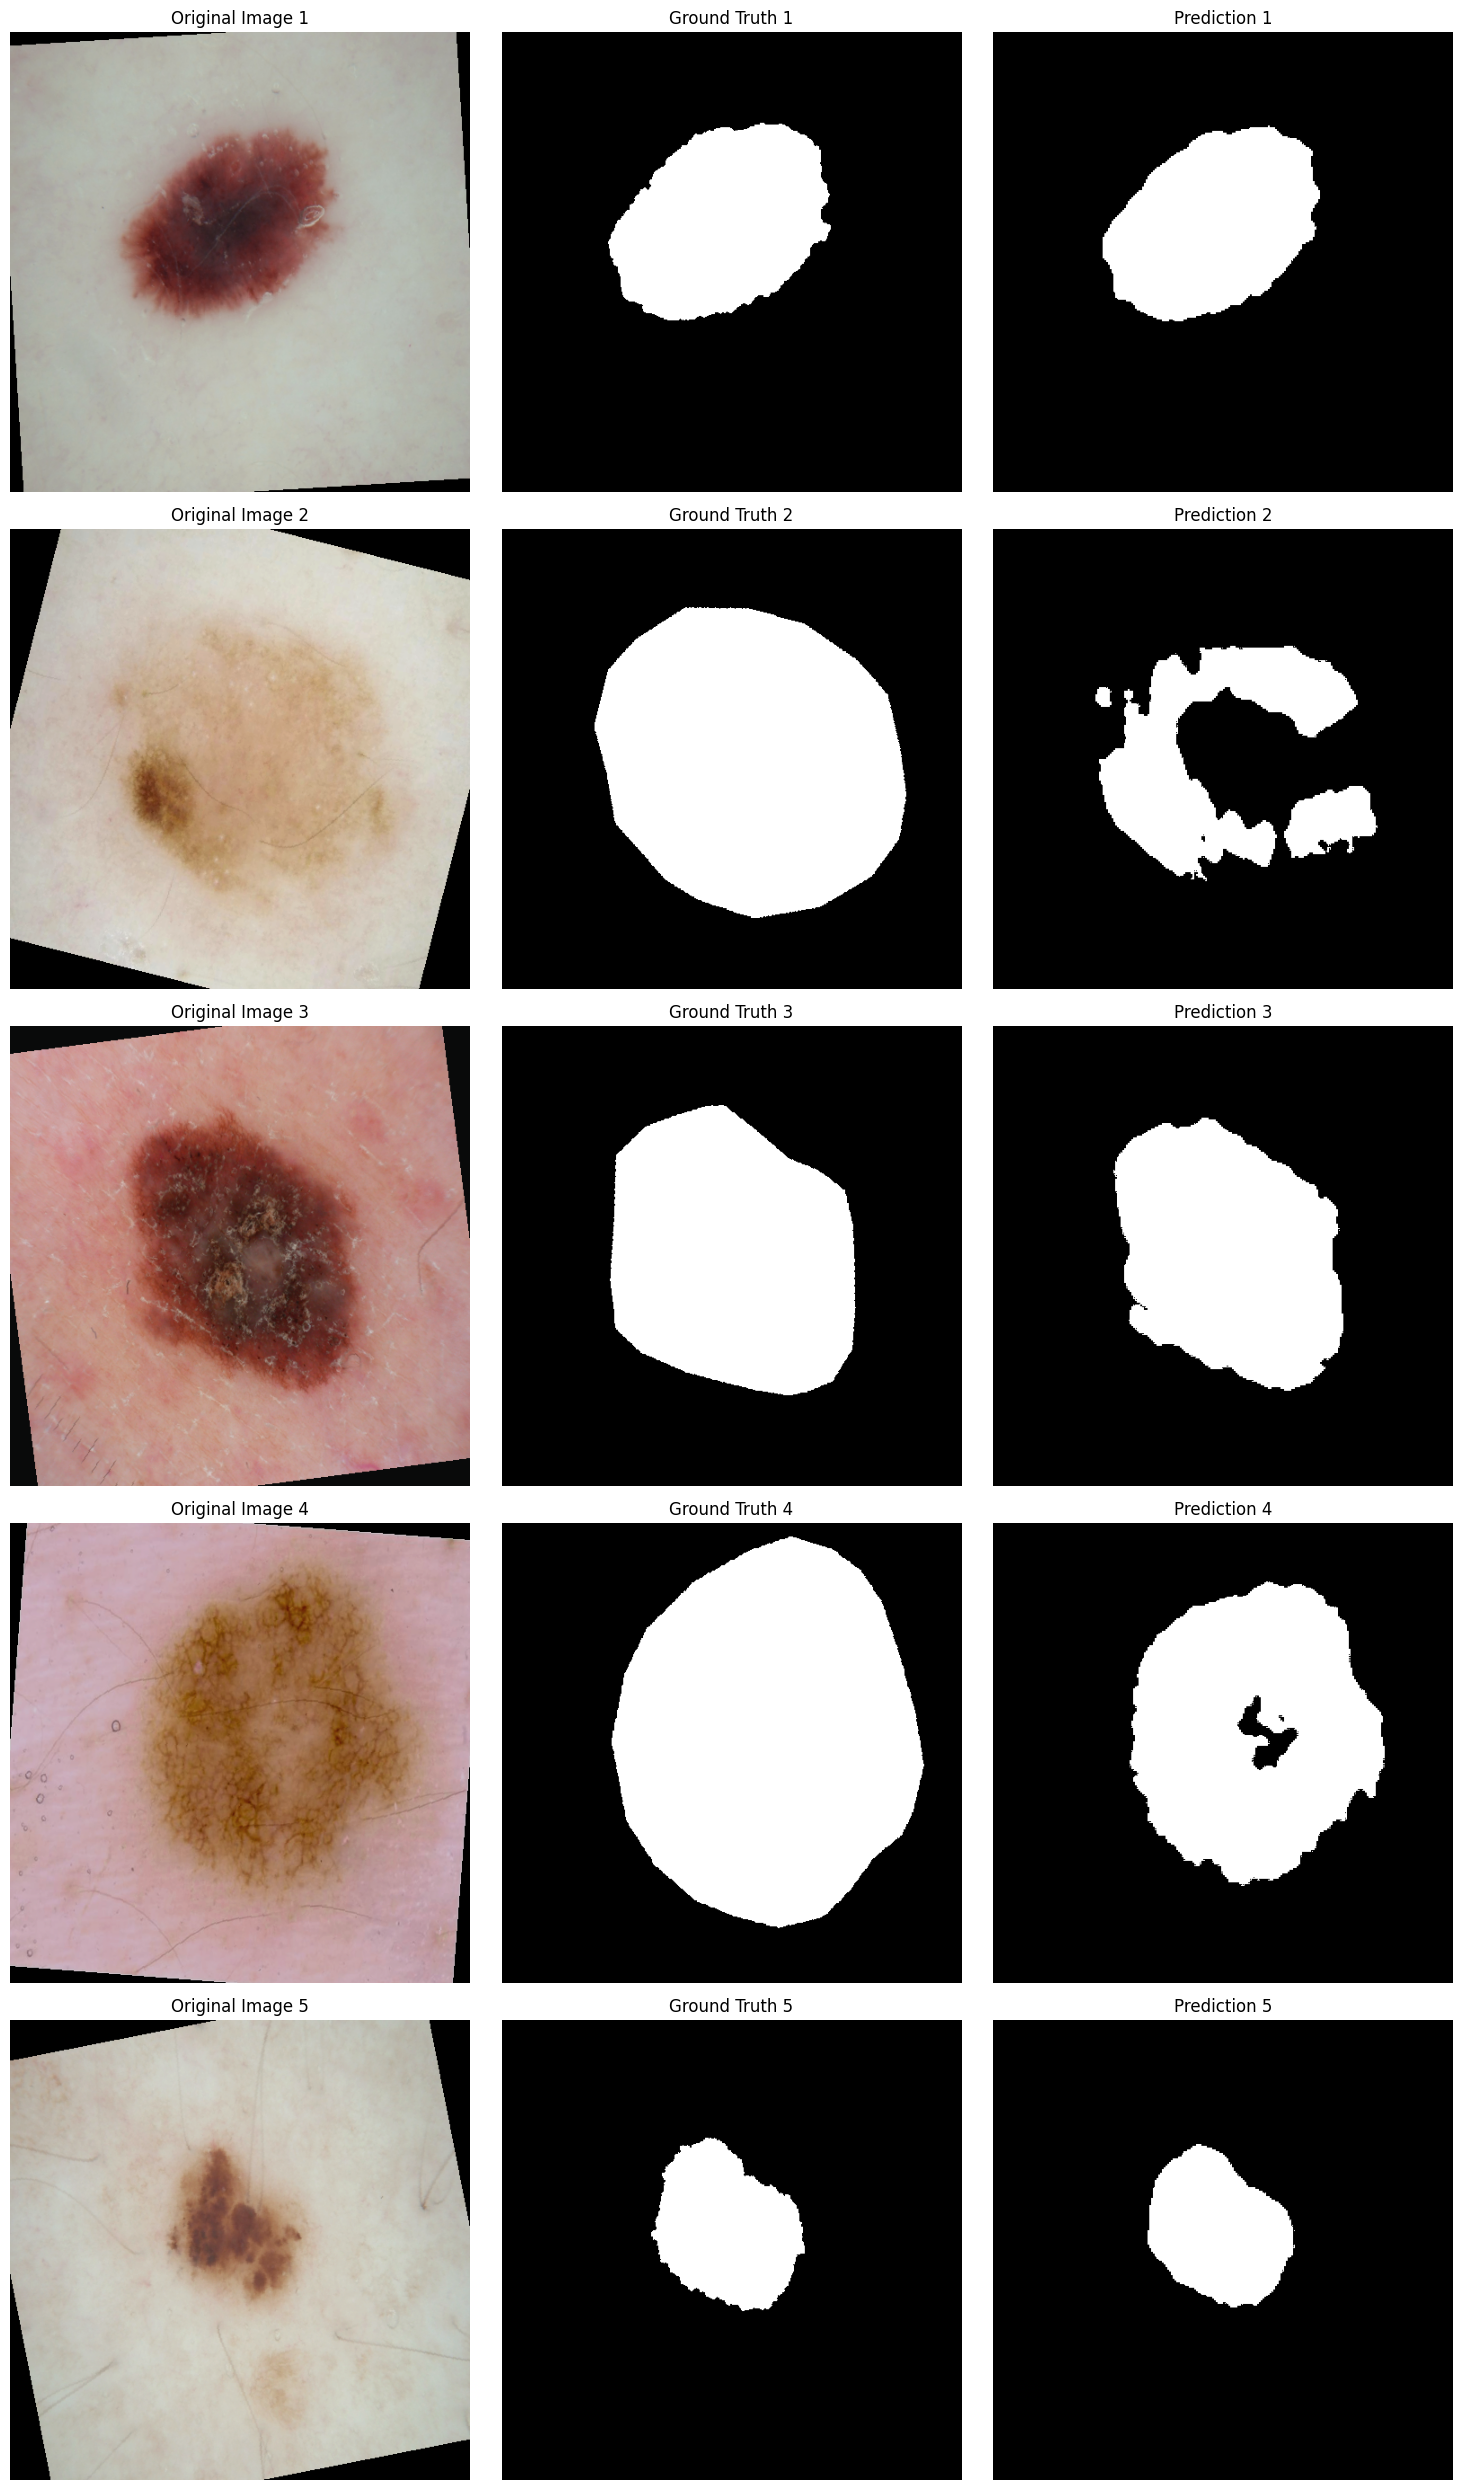


Calculating metrics for each prediction:
Average Metrics:
  Sensitivity: 0.7411
  Specificity: 0.9999
  Accuracy: 0.9123
  IoU: 0.7400
  Dice: 0.8337
  Hausdorff: 57.9398


In [ ]:
# Load the best model (if you want to load from saved checkpoint)
# model.load_state_dict(torch.load('best_segmentation_model.pth'))

# Visualize predictions on evaluation set
print("Visualizing predictions on evaluation set...")
images, masks, predictions = visualize_predictions(
    model, eval_loader, num_images=5, device=device
)

# Calculate metrics for each prediction
print("\nCalculating metrics for each prediction:")
# Calculate average metrics
avg_iou = np.mean([calculate_metrics(pred, mask)['IoU'] for pred, mask in zip(predictions, masks)])
avg_dice = np.mean([calculate_metrics(pred, mask)['Dice'] for pred, mask in zip(predictions, masks)])
avg_acc = np.mean([calculate_metrics(pred, mask)['Accuracy'] for pred, mask in zip(predictions, masks)])
avg_sens = np.mean([calculate_metrics(pred, mask)['Sensitivity'] for pred, mask in zip(predictions, masks)])
avg_spec = np.mean([calculate_metrics(pred, mask)['Specificity'] for pred, mask in zip(predictions, masks)])
avg_hausdorff = np.mean([calculate_metrics(pred, mask)['Hausdorff'] for pred, mask in zip(predictions, masks)])

print(f"Average Metrics:")
print(f"  Sensitivity: {avg_sens:.4f}")
print(f"  Specificity: {avg_spec:.4f}")
print(f"  Accuracy: {avg_acc:.4f}")
print(f"  IoU: {avg_iou:.4f}")
print(f"  Dice: {avg_dice:.4f}")
print(f"  Hausdorff: {avg_hausdorff:.4f}")